In [1]:
import numpy as np
import matplotlib.pyplot as plt

from openparticle.hamiltonians.free_hamiltonians import *
from openparticle.hamiltonians.yukawa_hamiltonians import *
from openparticle.hamiltonians.renormalized_yukawa_hamiltonian import *
from openparticle.utils import *
from openparticle.dlcq import momentum_states_partition


plt.rcParams["font.family"] = "Times New Roman"
plt.rc('text', usetex=True)

In [9]:
def m2_vs_res(res_vals, baryon_number, coupling = 1, mf = 1, mb = 1):


    evals = []
    K_vals = list(range(1, res_vals + 1))
    L_vals = []

    for res in K_vals:
        ham = yukawa_Hamiltonian(res = res, g = coupling, mf=mf, mb = mb)
        K_tmp_basis = momentum_states_partition(res)
        baryon_number_basis = impose_baryon_number(res, K_tmp_basis, baryon_number=baryon_number)

        tmp_mat = generate_matrix(ham, baryon_number_basis)

        if tmp_mat.shape != (0, 0):
            vals, vecs = np.linalg.eigh(tmp_mat)

            evals.append(min(vals))
            L_vals.append(2*np.pi * res)
            psi = numpy_to_fock(vecs[:, 0], baryon_number_basis)
            max_weight, state = max_fock_weight(psi)
            print(res, max_weight *  state, min(vals))

    return evals, L_vals


In [10]:
def J(res, g, mf):

    L = 2 * np.pi * res
    three_point = ParticleOperator({})
    for k1 in np.arange(-res + 1 / 2, res + 1 / 2, 1):
        for k2 in np.arange(-res + 1 / 2, res + 1 / 2, 1):
            op = (
                FermionField(k1, L, mf).psi_dagger.dot(
                    gamma0.dot(FermionField(k2, L, mf).psi)
                )[0][0]
            )
            if len(op.op_dict) != 0:
                three_point += op.normal_order()

    three_point.remove_identity()
    return g * three_point

1 (1+0j) * |((), (), ((0, 1),))⟩ 0.020000000000000004
2 (-0.9525876439527164+0j) * |((), (), ((1, 1),))⟩ -0.09653482928638163
3 (-0.7018756873374876+0j) * |((), (), ((2, 1),))⟩ -0.20711883025278696
4 (-0.6706912256588041+0j) * |((), (), ((1, 2),))⟩ -0.4479994708850985
5 (-0.5460682456704381+0j) * |((1,), (1,), ((0, 2),))⟩ -2.3007364676773108
6 (-0.5024725968635042+0j) * |((1,), (1,), ((0, 3),))⟩ -4.723738921687862


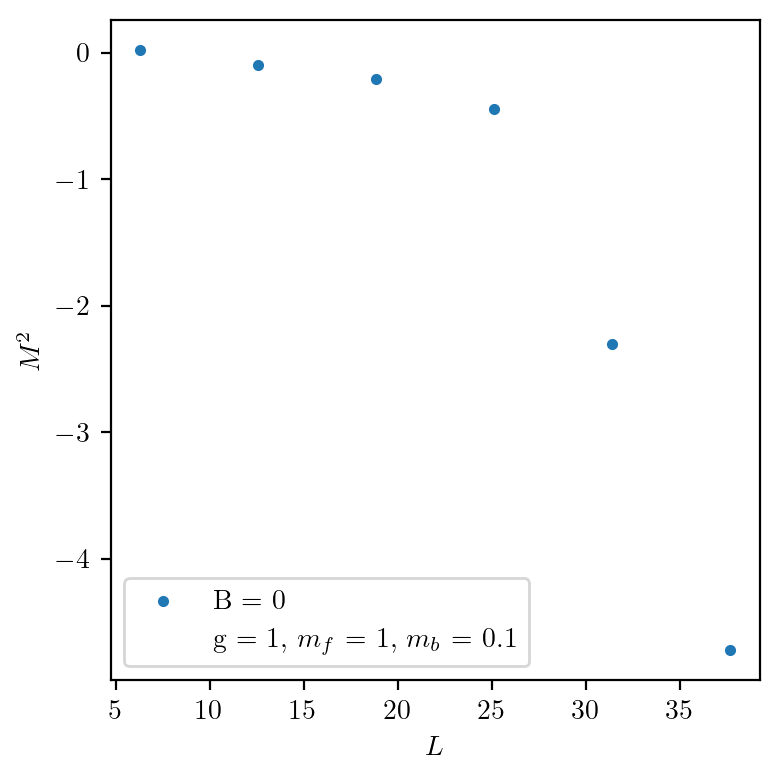

In [37]:
res = 6
g = 1
mf = 1
mb = 0.1
plt.figure(figsize = (4, 4), dpi = 200)
e, L = m2_vs_res(res_vals=res, baryon_number = 0, coupling = g, mf = mf, mb = mb)
plt.scatter(L, np.array(e), marker='.', label = 'B = 0')
plt.scatter([], [], color = 'white', label = f'g = {g}, $m_f$ = {mf}, $m_b$ = {mb}')
plt.xlabel(f'$L$')
plt.ylabel(f'$M^2$')
plt.tight_layout()
plt.legend()
plt.show()


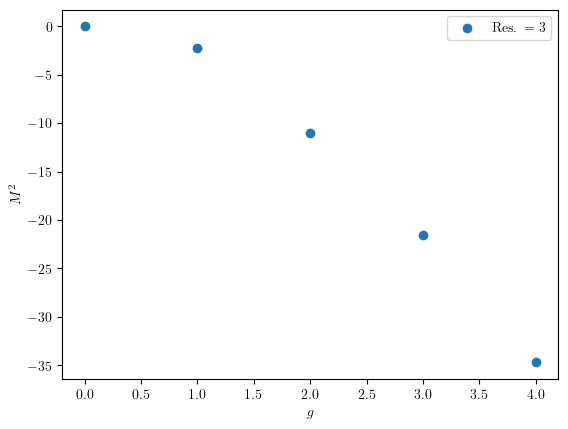

In [8]:
resolution = 3

mf = 1
mb = 0.1
K_tmp_basis = momentum_states_partition(res)
baryon_number_basis = impose_baryon_number(res, K_tmp_basis, baryon_number=0)

m2 = []
for coupling in range(0, 5):
    ham = yukawa_Hamiltonian(res = resolution, g = coupling, mf=mf, mb = mb)
    tmp_mat = generate_matrix(ham, baryon_number_basis)
    m2.append(min(np.linalg.eigvalsh(tmp_mat)))
plt.scatter(np.arange(0, 5, 1), m2, label = f'Res. = {resolution}')
plt.xlabel(f'$g$')
plt.ylabel(
    f'$M^2$'
)
plt.legend()

### Partition $H$ into blocks of definite $P^+$

Text(0.5, 1.0, 'Yukawa Hamiltonian at $L = 4\\pi$')

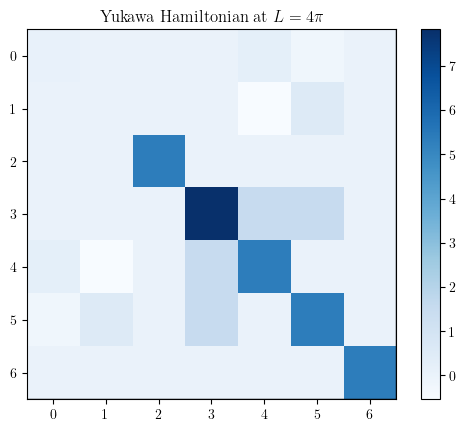

In [9]:
res = 2
min_res = res
g = 1
mf = 1
mb = 0.1

t = 0.1
treg = 0.01

basis = [momentum_states_partition(i)[j] for i in range(min_res, res + 1) for j in range(len(momentum_states_partition(i)))]
matrix = np.real(
        generate_matrix(yukawa_Hamiltonian(res, g = g, mf = mf, mb = mb), basis)
    )
# matrix = np.real(
#         generate_matrix(renormalized_Yukawa_hamiltonian(res = res, t = t, treg = treg, g = g, mf = mf, mb = mb), basis)
#     )
plt.imshow(
    matrix,
    cmap = 'Blues',
)
n_states_i = 0
for i in range(min_res, res + 1):
    n_states_i += len(momentum_states_partition(i))
    plt.axvline(x=n_states_i - 0.5, color='black', linewidth=1)
    plt.axhline(y=n_states_i - 0.5, color='black', linewidth=1)
plt.colorbar()
plt.title(f'Yukawa Hamiltonian at $L = {2 * res}\pi$')

In [5]:
def pdf(K, state, particle_type):
    #Calculates the parton distribution function for a given hadronic state

    particle_type_to_label = {'fermion': 'b',
                              'antifermion': 'd',
                              'boson': 'a'}
    
    
    f = []
    x_fermion_arr = np.array([k/K for k in np.arange(1/2, K, 1)])
    x_boson_arr = np.array([k/K for k in np.arange(1, K + 1, 1)])

    if particle_type == 'fermion' or 'antifermion':
        for x in x_fermion_arr:
            pdf_op = ParticleOperator(particle_type_to_label[particle_type] + str(int(x * K - 1/2)) + '^ ' + particle_type_to_label[particle_type] + str(int(x * K - 1/2)))
            f.append(get_matrix_element(state, pdf_op, state))

    elif particle_type == 'boson':
        for x in x_boson_arr:
            pdf_op = ParticleOperator(particle_type_to_label[particle_type] + str(int(x * K - 1)) + '^ ' + particle_type_to_label[particle_type] + str(int(x * K - 1)))
            f.append(get_matrix_element(state, pdf_op, state))

    return np.array(f)

Text(0.5, 1.0, 'Yukawa $Q = 0$ bound state PDF')

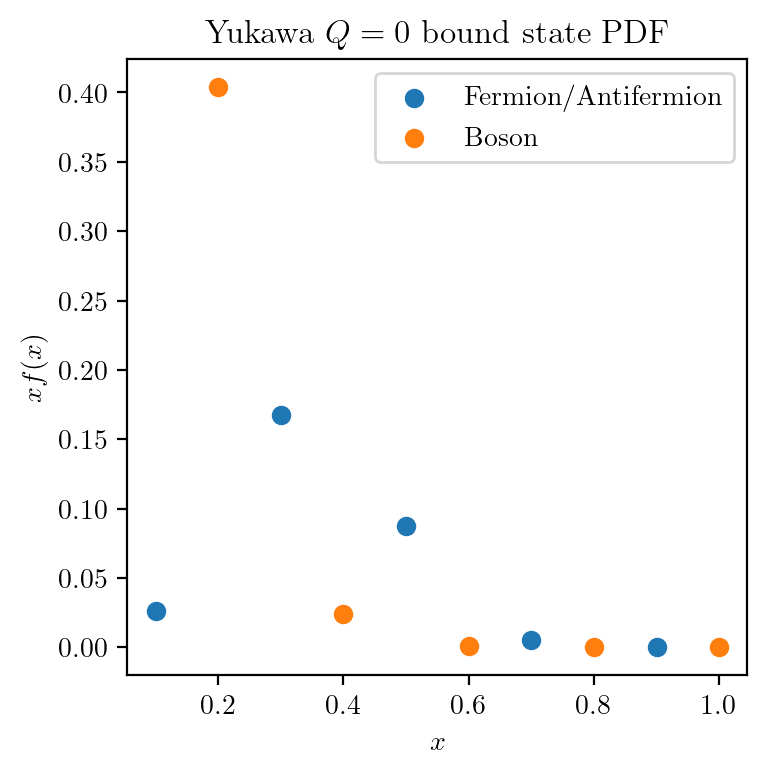

In [19]:
res = 5
g = 1
mf = 1
mb = 0.1
baryon_number = 0

ham = yukawa_Hamiltonian(res = res, g = g, mf = mf, mb = mb)
basis = momentum_states_partition(res)
basis = impose_baryon_number(res = res, basis = basis, baryon_number=baryon_number)
K_matrix = generate_matrix(ham, basis)

vals, vecs = np.linalg.eigh(K_matrix)
psi = numpy_to_fock(vecs[:, 0], basis)
max_weight, _ = max_fock_weight(psi)

fermion_pdf = pdf(res, psi, 'fermion')
antifermion_pdf = pdf(res, psi, 'antifermion')
boson_pdf = pdf(res, psi, 'boson')

x_fermion = np.array([k/res for k in np.arange(1/2, res, 1)])
x_boson = np.array([k/res for k in np.arange(1, res + 1, 1)])


plt.figure(figsize = (4, 4), dpi = 200)

if np.allclose(fermion_pdf, antifermion_pdf):
    plt.scatter(x_fermion, x_fermion * np.real(fermion_pdf), label = f'Fermion/Antifermion')

else:
    plt.scatter(x_fermion, x_fermion * np.real(fermion_pdf), label = f'Fermion')
    plt.scatter(x_fermion, x_fermion * np.real(antifermion_pdf), label = f'Antifermion')
plt.scatter(x_boson, x_boson * np.real(boson_pdf), label = f'Boson')
# plt.scatter([], [], color = 'white', label = f'{max_weight}')
plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$xf(x)$')
plt.title(f"Yukawa $Q = {baryon_number}$ bound state PDF")

## New $\mathcal{O}(g^2)$ Diagrams

In [2]:
def renormalized_m2_vs_res(res_vals, t, treg, g, mf, mb, baryon_number):


    evals = []
    K_vals = list(range(1, res_vals + 1))
    L_vals = []

    for res in K_vals:
        ham = renormalized_Yukawa_hamiltonian(res = res, t = t, treg = treg, g = g, mf = mf, mb = mb)
        K_tmp_basis = momentum_states_partition(res)
        baryon_number_basis = impose_baryon_number(res, K_tmp_basis, baryon_number=baryon_number)

        tmp_mat = generate_matrix(ham, baryon_number_basis)

        if tmp_mat.shape != (0, 0):
            vals, vecs = np.linalg.eigh(tmp_mat)

            evals.append(min(vals))
            L_vals.append(2*np.pi * res)
            psi = numpy_to_fock(vecs[:, 0], baryon_number_basis)
            max_weight, state = max_fock_weight(psi)
            print(res, max_weight *  state, min(vals))

    return evals, L_vals


In [42]:
ren = renormalized_Yukawa_hamiltonian(res = 5, t = 0.1, treg = 0, g = 1, mf = 1, mb = 0.1)

1 (1+0j) * |((), (), ((0, 1),))⟩ 0.047690710762723416
2 (0.9999991010041116+0j) * |((), (), ((1, 1),))⟩ 0.033786326085601184
3 (0.9999998607882226+0j) * |((), (), ((2, 1),))⟩ 0.0292242900846457
4 (-0.9999975794584692+0j) * |((), (), ((3, 1),))⟩ 0.02686749810216474
5 (0.9999975559947165+0j) * |((), (), ((4, 1),))⟩ 0.02547007000271417


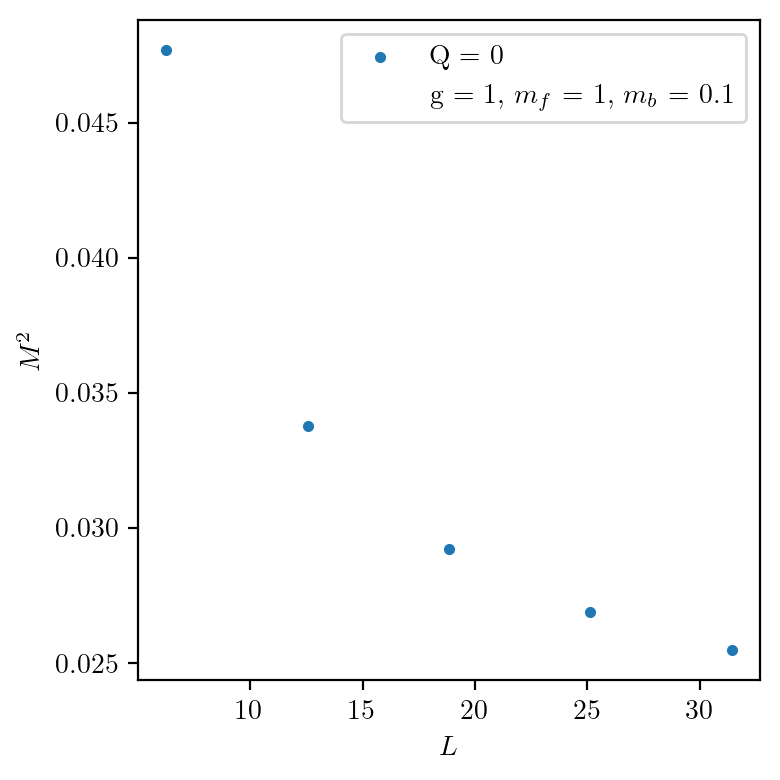

In [38]:
res = 5
t = 0.1
treg = 0
mf = 1
mb = 0.1
g = 1

plt.figure(figsize = (4, 4), dpi = 200)
e, L = renormalized_m2_vs_res(res_vals=res, t = t, treg = treg, g = g, mf = mf, mb = mb, baryon_number=0)
plt.scatter(L, np.array(e), marker='.', label = 'Q = 0')
plt.scatter([], [], color = 'white', label = f'g = {g}, $m_f$ = {mf}, $m_b$ = {mb}')
plt.xlabel(f'$L$')
plt.ylabel(f'$M^2$')
plt.tight_layout()
plt.legend()

plt.show()

Text(0.5, 1.0, 'Yukawa $Q = 0$ bound state PDF')

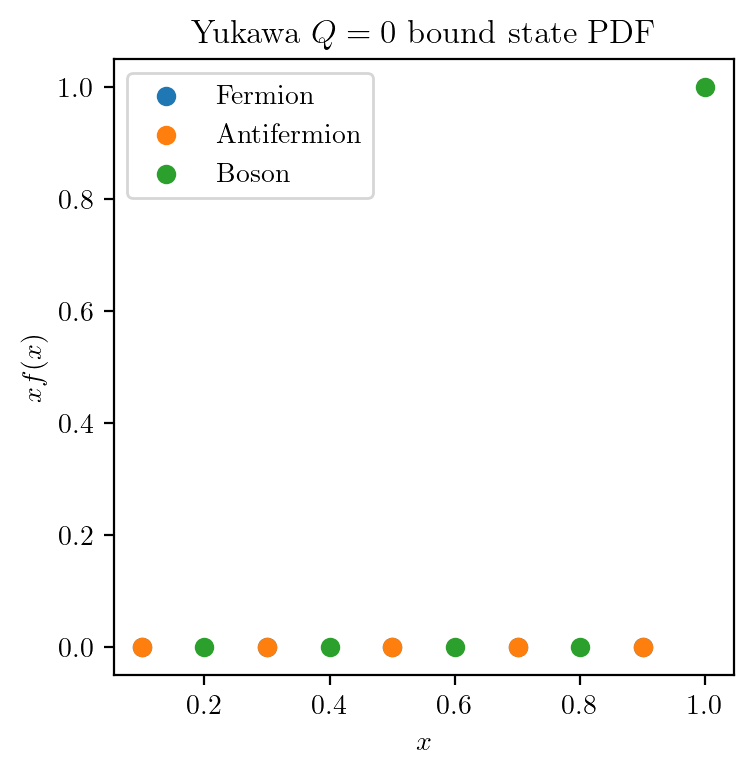

In [6]:
res = 5
t = 0.01
treg = 0
mf = 1
mb = 0.1
g = 1
baryon_number = 0

ham = renormalized_Yukawa_hamiltonian(res = res, t = t, treg = treg, g = g, mf = mf, mb = mb)
basis = momentum_states_partition(res)
basis = impose_baryon_number(res = res, basis = basis, baryon_number=baryon_number)
K_matrix = generate_matrix(ham, basis)

vals, vecs = np.linalg.eigh(K_matrix)
psi = numpy_to_fock(vecs[:, 0], basis)
max_weight, _ = max_fock_weight(psi)

fermion_pdf = pdf(res, psi, 'fermion')
antifermion_pdf = pdf(res, psi, 'antifermion')
boson_pdf = pdf(res, psi, 'boson')

x_fermion = np.array([k/res for k in np.arange(1/2, res, 1)])
x_boson = np.array([k/res for k in np.arange(1, res + 1, 1)])


plt.figure(figsize = (4, 4), dpi = 200)

if np.allclose(fermion_pdf, antifermion_pdf):
    plt.scatter(x_fermion, x_fermion * np.real(fermion_pdf), label = f'Fermion/Antifermion')

else:
    plt.scatter(x_fermion, x_fermion * np.real(fermion_pdf), label = f'Fermion')
    plt.scatter(x_fermion, x_fermion * np.real(antifermion_pdf), label = f'Antifermion')
plt.scatter(x_boson, x_boson * np.real(boson_pdf), label = f'Boson')
# plt.scatter([], [], color = 'white', label = f'{max_weight}')
plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$xf(x)$')
plt.title(f"Yukawa $Q = {baryon_number}$ bound state PDF")